In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

In [ ]:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 Sep 24 16:47 .
drwxr-xr-x 1 root root 4096 Sep 24 16:45 ..
drwxr-xr-x 4 root root 4096 Sep 22 13:41 .config
drwx------ 5 root root 4096 Sep 24 16:47 drive
drwxr-xr-x 1 root root 4096 Sep 22 13:42 sample_data


In [ ]:
cd /content

/content


In [ ]:
!ls -al

total 20
drwxr-xr-x 1 root root 4096 Sep 24 16:47 .
drwxr-xr-x 1 root root 4096 Sep 24 16:45 ..
drwxr-xr-x 4 root root 4096 Sep 22 13:41 .config
drwx------ 5 root root 4096 Sep 24 16:47 drive
drwxr-xr-x 1 root root 4096 Sep 22 13:42 sample_data


In [ ]:
PATH = '/content/drive/MyDrive/'

# **1. 데이터 불러오기**

In [ ]:
train = pd.read_csv(PATH + "train_data.csv")
test = pd.read_csv(PATH + "대구시뉴스기사크롤링_train_ver07.csv")
submission = pd.read_csv(PATH + "sample_submission.csv")

In [ ]:
test

,Unnamed: 0,title
0,0,23일 1592명 코로나19 확진…사망자 2명
1,1,교육청 전국도교육감협의회 총회 개최
2,2,국민의힘 당 스마트 물 산업 육성 정책토론회 개최
3,3,수도권 주택 가격 35% 거품…지방도 세종 60%· 23% 등
4,4,미래융복합 교통인프라 구축 업무 협약 체결
...,...,...
1995,1995,변호사회 '애산인권상' 초대 수상자 이용수 할머니 서울변호사회 '민인...
1996,1996,경북연구원 분리해 '자체 연구원 설립' 추진
1997,1997,보건대 예비 언어재활사 선서식 개최
1998,1998,국제오페라축제 23일 ‘토란도트’로 개막



> 카테고리 별 기사 개수





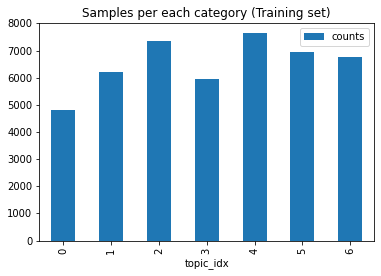

In [ ]:
# 작가별 분포도 확인 
train.groupby(train.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each category (Training set)")



> 문장 길이 분포도 확인


*  모델 구현 시 sequence에 적용할 max length를 잡아주기 위함이다.
*  아래의 결과를 바탕으로 모델의 max length는 14로 세팅한다.





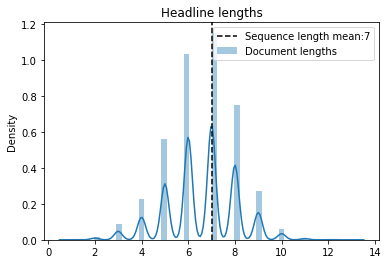



 가장 긴 문장은 13 개의 단어를, 가장 짧은 문장은 1 개의 단어를 가지고 있다.


In [ ]:
train['doc_len'] = train.title.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Headline lengths')
    plt.legend()
    plt.show()
    print('\n')
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있다.")

plot_doc_lengths(train)

# **2. Vectorization**



> 2.1 Tokenization
* train, test 데이터를 인덱스 없이 배열로 만든다.



In [ ]:
X_train = np.array([x for x in train['title']])
X_test = np.array([x for x in test['title']])
Y_train = np.array([x for x in train['topic_idx']])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(45654,)
(2000,)
(45654,)


In [ ]:
print(X_train)
print(X_test)
print(Y_train)

['인천→핀란드 항공기 결항…휴가철 여행객 분통' '실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화'
 '이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것' ... '게시판 키움증권 2020 키움 영웅전 실전투자대회'
 '답변하는 배기동 국립중앙박물관장' '2020 한국인터넷기자상 시상식 내달 1일 개최…특별상 김성후']
[' 23일 1592명 코로나19 확진…사망자 2명' '교육청 전국도교육감협의회 총회 개최'
 '국민의힘 당 스마트 물 산업 육성 정책토론회 개최' ... '보건대 예비 언어재활사 선서식 개최'
 '국제오페라축제 23일 ‘토란도트’로 개막' ' 달성군 석회유황합제 수요조사 벌인다']
[4 4 4 ... 1 2 2]




> 2.2 Tokenizer
* Tokenizer는 데이터에 출현하는 모든 단어의 개수를 세고 빈도수로 정렬한 후 num_words에 지정된 만큼 숫자로 반환하고, 나머지는 0으로 반환한다.



In [ ]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
vocab_size = 2000  

tokenizer = Tokenizer(num_words = vocab_size)  
tokenizer.fit_on_texts(X_train) # Tokenizer 에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train)    # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)      # 문장 내 모든 단어를 시퀀스 번호로 변환

print(len(sequences_train), len(sequences_test))

45654 2000


# **3. Embeding**

In [ ]:
# 변환된 시퀀스 번호를 이용해 단어 임베딩 벡터 생성
word_index = tokenizer.word_index



> 독립변수 데이터 전처리
* 뉴스 헤드라인의 길이가 제각각이기 때문에 벡터의 크기가 모두 다르다.
* 그렇기 때문에 최대 시퀀스 길이 크기(14)만큼 넉넉하게 늘린다.
* 패딩(padding) 작업을 통해 나머지 빈 공간은 0으로 채운다.



In [ ]:
# 위에서 그래프 확인 후 정했다.
max_length = 14   
padding_type='post'

train_x = pad_sequences(sequences_train, padding='post', maxlen=max_length)
test_x = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

print(train_x.shape, test_x.shape)

(45654, 14) (2000, 14)




> 종속변수(카테고리) 데이터 전처리
* 우리의 데이터는 순서가 없는 데이터이다.
* 연속성이 없다는 것을 확실히 하기 위해 원-핫 인코딩을 하는 것이 더 좋은 결과를 이끌어 낼 수 있다.



In [ ]:
train_y = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩
print(train_y)
print(train_y.shape)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(45654, 7)


# **4. Modeling**



> 4.1 양방향 LSTM
* 문장 분석에 가장 특화된 모델은 LSTM을 사용한다.
* 또한 데이터 길이가 길어도 성능은 저하되지 않는 양방향 LSTM을 사용하였다.



In [ ]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'
#oov_tok = "<OOV>"



> 4.2 손실함수
* 여러 개의 카테고리 중 해당되는 카테고리 하나를 맞추는 문제이므로 손실함수는 categorical_crossentropy를 사용한다.



In [ ]:
model = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 128, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 32)),
        Dense(7, activation='softmax') 
    ])
    
model.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 14, 200)           400000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 14, 256)          336896    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 14, 128)          164352    
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 14, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 14, 128)          98816     
 onal)                                                

In [ ]:
# 모델 실행해보기
history = model.fit(train_x, train_y, epochs=50, batch_size=100, validation_split= 0.2) 
  # 양방향 LSTM 레이어에서는 batch size 를 100으로 잡고 50회 학습 해보았다.

Epoch 1/50
366/366 [==============================] - 24s 33ms/step - loss: 1.1873 - accuracy: 0.5429 - val_loss: 1.3937 - val_accuracy: 0.4745
Epoch 2/50
366/366 [==============================] - 9s 23ms/step - loss: 0.8406 - accuracy: 0.7115 - val_loss: 1.1864 - val_accuracy: 0.5801
Epoch 3/50
366/366 [==============================] - 9s 23ms/step - loss: 0.7752 - accuracy: 0.7357 - val_loss: 1.1731 - val_accuracy: 0.5653
Epoch 4/50
366/366 [==============================] - 9s 24ms/step - loss: 0.7359 - accuracy: 0.7472 - val_loss: 1.1284 - val_accuracy: 0.5781
Epoch 5/50
366/366 [==============================] - 9s 24ms/step - loss: 0.7137 - accuracy: 0.7544 - val_loss: 1.1497 - val_accuracy: 0.5704
Epoch 6/50
366/366 [==============================] - 9s 24ms/step - loss: 0.6933 - accuracy: 0.7603 - val_loss: 1.1541 - val_accuracy: 0.5997
Epoch 7/50
366/366 [==============================] - 9s 24ms/step - loss: 0.6718 - accuracy: 0.7647 - val_loss: 1.1363 - val_accuracy: 0.590



> **4.3 결과**
* loss 값은 줄어드나, val_loss 값은 점점 상승한다.
* accuracy 값도 줄어드나, val_accuracy 값은 제대로 나오지 않는다.
* 교차 검증을 통해 모델 성능 평가 일반화를 한다. 



<function matplotlib.pyplot.show(*args, **kw)>

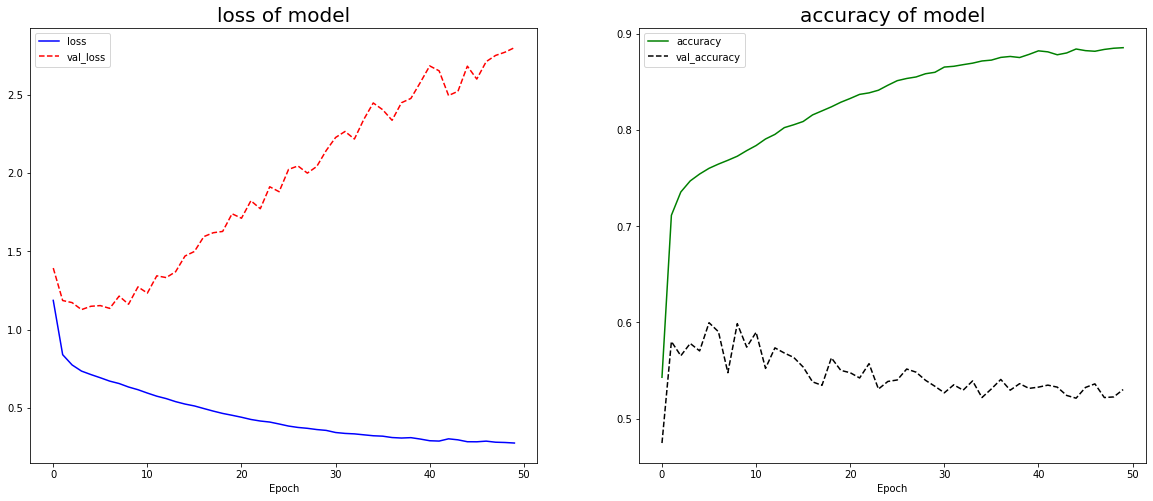

In [ ]:
# 모델 학습 결과 확인
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.title('loss of model', fontsize= 20)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of model', fontsize= 20)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show



> **4.4 교차 검증**
* 기존보다 개선된 결과 값이다.
* val_loss, val_accuracy 결과값을 보면서 조기종료 옵션을 추가한다.



In [ ]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
test_y = np.zeros((test_x.shape[0], 7))

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
                      
    test_y += model.predict(test_x) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

training model for CV #1
Epoch 1/10
72/72 [==============================] - 2s 29ms/step - loss: 0.5983 - accuracy: 0.8221 - val_loss: 0.5276 - val_accuracy: 0.8315
Epoch 2/10
72/72 [==============================] - 2s 28ms/step - loss: 0.4671 - accuracy: 0.8411 - val_loss: 0.5169 - val_accuracy: 0.8315
Epoch 3/10
72/72 [==============================] - 2s 28ms/step - loss: 0.4294 - accuracy: 0.8510 - val_loss: 0.5210 - val_accuracy: 0.8311
Epoch 4/10
72/72 [==============================] - 2s 28ms/step - loss: 0.4059 - accuracy: 0.8560 - val_loss: 0.5251 - val_accuracy: 0.8275
Epoch 5/10
72/72 [==============================] - 2s 29ms/step - loss: 0.3890 - accuracy: 0.8597 - val_loss: 0.5342 - val_accuracy: 0.8264
Epoch 5: early stopping
training model for CV #2
Epoch 1/10
72/72 [==============================] - 2s 28ms/step - loss: 0.4538 - accuracy: 0.8447 - val_loss: 0.4295 - val_accuracy: 0.8496
Epoch 2/10
72/72 [==============================] - 2s 27ms/step - loss: 0.4194 

In [ ]:
# 테스트 데이터의 예측값 확인
test_y

array([[9.42207384e-05, 6.46412023e-03, 1.06590004e-01, ...,
        8.77544731e-01, 1.16109960e-03, 7.78872182e-03],
       [1.05167732e-01, 2.23318860e-02, 3.02882671e-01, ...,
        7.22031398e-02, 4.27305931e-02, 7.09192210e-03],
       [9.60311651e-01, 1.32576446e-03, 2.75902478e-02, ...,
        4.90793999e-03, 6.63343686e-04, 3.92717845e-03],
       ...,
       [1.05167730e-01, 2.23318860e-02, 3.02882690e-01, ...,
        7.22031351e-02, 4.27305894e-02, 7.09192234e-03],
       [8.31914731e-05, 1.20368043e-03, 2.34267641e-02, ...,
        1.26236059e-03, 4.63340676e-03, 1.28436219e-04],
       [8.22364371e-02, 1.08802063e-01, 2.27782913e-01, ...,
        1.14963027e-01, 7.20882816e-02, 1.22260993e-01]])

In [ ]:
topic = []
for i in range(len(test_y)):
    topic.append(np.argmax(test_y[i]))

In [ ]:
submission.to_csv(PATH + '대구시output.csv',index = False)

# **5. 결과값 대입**

In [ ]:
# sample_submission 에 대입
submission['topic_idx'] = topic
submission

,index,topic_idx
0,0,4
1,1,3
2,2,0
3,3,1
4,4,2
...,...,...
1995,1995,3
1996,1996,2
1997,1997,3
1998,1998,3
